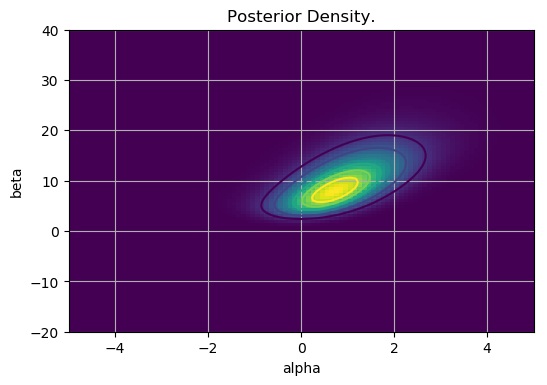

In [2]:
'''
Assignment 5
'''

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import multivariate_normal
from random import random as rand
import psrf

mpl.rcParams['figure.dpi']=100

# seed a random state
rng = np.random.RandomState(0)

# Data
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

#
#Computation of the log densities
#
alpha = np.linspace(-5, 5, 100)
beta = np.linspace(-20, 40, 100)

#Inverse logit function
#logit_inverse = 1 / (1 + np.exp(-(alpha[:,None] + beta[:,None,None] * x)))
#Likelihood
#likelihood = np.prod(logit_inverse**y * (1 - logit_inverse)**(n - y), axis=2)

#Joint normal prior distribution parameters --> bivariate normal distribution parameters (prior)
mu_alpha = 0 
mu_beta = 10
sigma_alpha = 2
sigma_beta = 10
#correlation
p = 0.5 

mean = np.array([mu_alpha,mu_beta])
covariance = np.array([[sigma_alpha**2,p*sigma_alpha*sigma_beta],[p*sigma_alpha*sigma_beta,sigma_beta**2]])

prior = multivariate_normal(mean,covariance)

#Grid of points using alpha and beta
xv,yv = np.meshgrid(alpha,beta)
pos = np.empty(xv.shape + (2,))
pos[:, :, 0] = xv
pos[:, :, 1] = yv


#Log posterior for alpha and beta
def bioassaylp(a,b,x, y, n):
    # last axis for the data points
    a = np.expand_dims(a, axis=-1)
    b = np.expand_dims(b, axis=-1)
    # these help using chain rule in derivation
    t = a + b*x
    et = np.exp(t)
    z = et/(1.+et)
    # negative log posterior (error function to be minimized)
    log_likelihood = np.sum(y*np.log(z)+ (n-y)*np.log(1.0-z), axis=-1)
    a_b = np.column_stack((a,b))
    log_prior = prior.logpdf(a_b)
    log_posterior = log_prior+log_likelihood
    return log_posterior

pos_arr = pos.reshape(100*100,2)
log_posterior = (bioassaylp(pos_arr[:,0],pos_arr[:,1],x,y,n)).reshape(100,100)
posterior = np.exp(log_posterior)


plt.imshow(posterior,origin='lower', aspect='auto', extent=(alpha[0], alpha[-1], beta[0], beta[-1]))
plt.contour(alpha,beta,posterior)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Posterior Density.')
plt.grid(True)
plt.show()


In [3]:
#
#Metropolis algorithm
#

#Number of warm up samples to remove
warm_up = 6000
#Number of samples to generate
number_samples = 6000

def metropolis(theta_0,log_post=bioassaylp,warm_up=warm_up,number_samples=number_samples):
    #Initialization of loop variables
    limit =number_samples+warm_up
    theta = np.zeros((limit,2))
    theta[0]=theta_0
    i=1
    cov = [[2,0],[0,6]]

    while i <limit:
        theta_temp = multivariate_normal(mean=theta[i-1],cov=cov).rvs(1)
        r = np.exp(log_post(theta_temp[0],theta_temp[1],x,y,n)-log_post(theta[i-1][0],theta[i-1][1],x,y,n))
        pr = min(1,r)
        u = rand()

        # Accept theta_temp with probability pr
        if(u<=pr):
            #print("theta pred: {0} Accepted , r = {1}, pr = {2}, u = {3}".format(theta_temp,r,pr,u))
            theta[i]=theta_temp
        # Reject theta_temp with probability 1-pr
        else:
            #print("theta pred: {0} Rejected , r = {1}, pr = {2}, u = {3}".format(theta_temp,r,pr,u))
            theta[i]=theta[i-1]
        i+=1 
    return theta

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in multiply


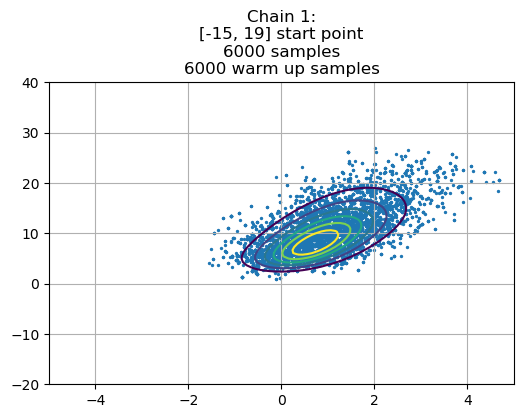

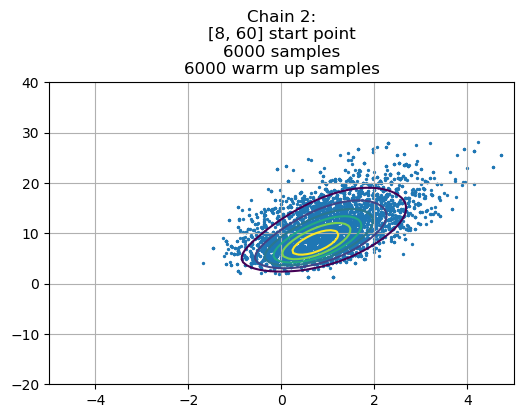

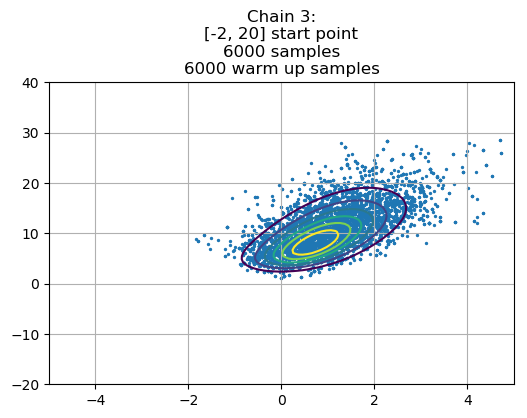

In [75]:
#
#Plot of the draws of alpha and beta
#
chains = []
starting_points = [[-15,19],[8,60],[-2,20]]
for theta_0 in starting_points:
    chains.append(metropolis(theta_0=theta_0)[warm_up:])

for i in range(len(chains)):
    plt.scatter(chains[i][:,0],chains[i][:,1],2)
    plt.contour(alpha,beta,posterior)
    plt.xlim([-5,5])
    plt.ylim([-20,40])
    plt.title("Chain {0}:\n[{1}, {2}] start point\n{3} samples\n{4} warm up samples".format(
        i+1,starting_points[i][0],starting_points[i][1],number_samples,warm_up))
    plt.grid(True)
    plt.show()

In [76]:
#
#R-hat values for alpha and beta
#
r_hat = psrf.psrf(chains)
print("Alpha R-hat value: {0}".format(r_hat[0]))
print("Beta R-hat value: {0}".format(r_hat[1]))

Alpha R-hat value: 1.0037405564043462
Beta R-hat value: 1.0063109315975844
